<a href="https://colab.research.google.com/github/IceOnDunes/speech-recognition/blob/main/Data_generator_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
""" Classe Data generator pour génerer les données par batch durant l'apprentissage "on the fly" 
    code de classe inspiré de : https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    Ajout de la partie pre-traitement (normalisation, calcul de spectrogramme, padding ...) 
"""
from CTCModel import CTCModel as CTCModel
from tensorflow.keras.optimizers  import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input,BatchNormalization, Dropout, Activation, TimeDistributed, Activation, Bidirectional, LSTM
from tensorflow.keras.utils import Sequence
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import string
import librosa
from scipy.io import wavfile


In [2]:
class DataGenerator(tf.keras.utils.Sequence):

    'Generates data for Keras'
    def __init__(self, list_IDs,shuffle=False, batch_size=32, window_len=128,nfft=256,hop_len=127):
        'Initialization'
        self.list_IDs = list_IDs
        self.hop_len = hop_len
        self.batch_size = batch_size
        self.nfft= nfft
        self.window_len = window_len
        self.shuffle = shuffle
        self.on_epoch_end()
        self.char_dict =  { ' ': 0,
                            'a': 1,
                            'b' : 2,
                            'c' : 3,
                            'd' : 4,
                            'e' : 5,
                            'f' : 6,
                            'g' : 7,
                            'h' : 8,
                            'i' : 9,
                            'j' : 10,
                            'k' : 11,
                            'l' : 12,
                            'm' : 13,
                            'n' : 14,
                            'o' : 15,
                            'p' : 16,
                            'q' : 17,
                            'r' : 18,
                            's' : 19,
                            't' : 20,
                            'u' : 21,
                            'v' : 22,
                            'w' : 23,
                            'x' : 24,
                            'y' : 25,
                            'z' : 26
                            }
                          
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def get_data (self,data_IDs):
      """renvoie le son ainsi que son text associé normalisé """

      son = []
      text = []

      "récuperer les characters de ponctuations"
      ponctuation_char = set(string.punctuation)

      for d in data_IDs:
          fe, audio = wavfile.read(d)
          moyenne = audio.mean()
          std = audio.std()
          audio = (audio-moyenne) / std
          son.append(audio)

          text_path = d[:-8] + '.TXT'  # conversion chemin audio vers chemin text correspondant
          txt = open( text_path, 'r')
          ligne = txt.readline()


          # normaliser les texts
          result = ''.join([i for i in ligne if (not i.isdigit() and i not in ponctuation_char )]).lstrip().lower().replace("\n", '')
          text.append(result)
      return son, text


    def get_padded_mel_spectro(self,audio, maxlen):
        mel_spectro =np.log(np.absolute(librosa.stft(audio.astype(float),  n_fft= self.nfft,hop_length=self.hop_len, win_length=self.window_len)))
        x_len = mel_spectro.shape[1]

        padded_spectro = tf.keras.preprocessing.sequence.pad_sequences(mel_spectro,maxlen=maxlen, dtype='float', padding='post', truncating='post',value=float(255))
        return padded_spectro, x_len

    def extract_features(self, x_data_init):
      #extract longest spectrogram length
        mel_spectrogram = np.log(np.absolute(librosa.stft(max(x_data_init, key=len).astype(float),n_fft= self.nfft,hop_length=self.hop_len, win_length=self.window_len)))
        x_max_length = mel_spectrogram.shape[1]
        # x_max_length = 640
        x_data = []
        x_data_len = []

        for i in range(len(x_data_init)):

            padded_spectro, x_len = self.get_padded_mel_spectro(x_data_init[i], maxlen=x_max_length)

            x_data.append(padded_spectro.T)
            x_data_len.append(x_len) 

        #convert to array
        data_input = np.array(x_data)
        input_length = np.array(x_data_len)

        return data_input,input_length

#changer les noms
    def encode_text(self, y_data_init):

        y_max_length = len(max(y_data_init, key=len))
        y_data = []
        y_data_len = []

        for i in range(len(y_data_init)):
            encoded = []
            for c in y_data_init[i]:
                if c=='':
                  # changer map char et ajouter en haut
                    encoded.append(self.char_dict['<SPACE>'])
                else:
                  encoded.append(self.char_dict[c])

            y_len = len(encoded)


            for j in range(len(encoded), y_max_length):
                    encoded.append(float(255))
            y_data.append(encoded)
            y_data_len.append(y_len)

        # convert to array
        y_data = np.array(y_data)
        label_length = np.array(y_data_len)

        return y_data, label_length


    def __data_generation(self, list_IDs_temp):
       # Generate data
        x_data_init, y_data_init = self.get_data(list_IDs_temp)

        #compute the spec frame of the longest audio
        x_data, input_length = self.extract_features(x_data_init)
        y_data, label_length = self.encode_text(y_data_init)

        inputs = [x_data, y_data, input_length, label_length]
        outputs = np.zeros([self.batch_size])
        return inputs,outputs

In [3]:
def update_dataframe(csv_path):
    ## enleve les colonnes dont on n'a pas besoin
    data = pd.read_csv(csv_path)
    data = data.dropna(subset=['filename'])
    data = data.drop(['test_or_train', 'dialect_region', 'filename',
                      'path_from_data_dir', 'is_audio', 'is_word_file',
                      'is_phonetic_file', 'is_sentence_file',
                      'speaker_id', 'index'], axis=1)

    data = data[(data.is_converted_audio == True)]
    data = data.reset_index(drop=True)
    paths = list(data['path_from_data_dir_windows'])
    return data,paths

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !cp -r /content/drive/MyDrive/Speech_recognition_dataset  /content/

In [5]:
#

# drive.mount('/content/drive')
train_csv = '/content/drive/MyDrive/Speech_recognition_dataset/train_data.csv' #path to train.csv
path = '/content/drive/MyDrive/Speech_recognition_dataset/data/' #path to TIMIT data


train_dataframe,train_path = update_dataframe(train_csv)

train_path = [path + x.replace('\\', '/') for x in train_path]
valid_path=train_path[4160:-12]
train_path=train_path[0:4160]

In [6]:
print(len(train_path))
print(len(valid_path))
data_params = {'window_len' : 128,
               'hop_len' : 127,
               'nfft' : 256,
               'batch_size' : 32,
               'shuffle' : True
               }

print("Data Generation")
training_generator = DataGenerator(train_path[0:64], **data_params)
validation_generator = DataGenerator(valid_path[0:64], **data_params)

4160
448
Data Generation


In [ ]:
# !pip install keras_ctcmodel
# x_data_init, y_data_init = training_generator.get_data(train_path[0:32])
# x_data, input_length = training_generator.extract_features(x_data_init)


In [ ]:
# print(input_length)
# print(x_data.shape)

# Model

In [7]:
from tensorflow.keras.layers import Masking

units=500
nb_features=129
optimizer = Adam(lr=0.0001)
nb_labels=28

x_input = Input((None,nb_features))
x = Masking(mask_value=0)(x_input)
print(x.shape)
x = Bidirectional(LSTM(units,return_sequences=True))(x)
print(x.shape)
x = Bidirectional(LSTM(units,return_sequences=True))(x)
print(x.shape)
x = Bidirectional(LSTM(units, return_sequences=True))(x)
print(x.shape)
x = Bidirectional(LSTM(units,return_sequences=True))(x)
print(x.shape)
x = Bidirectional(LSTM(units,return_sequences=True))(x)
print(x.shape)
y_pred = TimeDistributed(Dense(units=nb_labels, activation='softmax'), name='softmax')(x)
print(y_pred.shape)
x_1 = tf.keras.Model(inputs=x_input, outputs= y_pred)
x_1.summary()






/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


(None, None, 129)
(None, None, 1000)
(None, None, 1000)
(None, None, 1000)
(None, None, 1000)
(None, None, 1000)
(None, None, 28)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 129)]       0         
                                                                 
 masking (Masking)           (None, None, 129)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 1000)       2520000   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 1000)       6004000   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 1000)       6004000 

In [8]:
# CTC

model =CTCModel ([x_input], [y_pred])
model.compile(optimizer=optimizer)
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 129)]  0           []                               
                                                                                                  
 masking (Masking)              (None, None, 129)    0           ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 1000)   2520000     ['masking[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, None, 1000)  6004000     ['bidirectional[0][0]']          
 )                                                                                          

In [17]:
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
            save_weights_only=True,
            verbose=1)

In [26]:
with tf.device('/device:GPU:0'):
  history=model.fit(training_generator,epochs=1,validation_data=validation_generator,callbacks=[cp_callback])


2/2 [==============================] - ETA: 0s - loss: 904.1401  
Epoch 00001: saving model to training_1/cp.ckpt
2/2 [==============================] - 114s 54s/step - loss: 904.1401 - val_loss: 292.4557


In [35]:
# # model.save('/content/drive/MyDrive/Speech_recognition_dataset/model_3')
# import tensorflow as tf
model.save_model('training_1')

dict_keys(['loss', 'val_loss'])


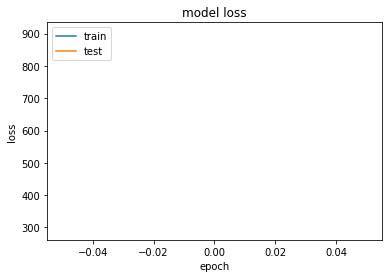

In [36]:
import matplotlib.pyplot as plt
print(history.history.keys())

# summarize
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
test_csv = '/content/drive/MyDrive/Speech_recognition_dataset/test_data.csv' #path to test.csv
path = '/content/drive/MyDrive/Speech_recognition_dataset/data/' #path to TIMIT data


test_dataframe,test_path = update_dataframe(test_csv)

test_path = [path + x.replace('\\', '/') for x in test_path]
test_path=test_path[0:-4]

test_generator = DataGenerator(test_path, **data_params)

In [10]:
x_data_init, y_data_init = test_generator.get_data(test_path[0:4])

#compute the spec frame of the longest audio
x_data, input_length = test_generator.extract_features(x_data_init)
y_data, label_length = test_generator.encode_text(y_data_init)

In [11]:

print("Evaluation")
model.save_model('/content/drive/MyDrive/Speech_recognition_dataset')
from CTCModel import CTCModel as CTCModel
model.evaluate([x_data, y_data, input_length, label_length],batch_size=32,metrics=['ler', 'ser'])



# for i in range(10):  # print the 10 first predictions
#     print("Prediction :", [j for j in pred[i] if j!=-1])

Evaluation
1/1 [==============================] - 16s 16s/step


[array([0.88235295, 0.9117647 , 0.9302326 , 0.8888889 ], dtype=float32), 1.0]

In [26]:
model.load_weights('/content/drive/MyDrive/Speech_recognition_dataset/model_weights.hdf5')

In [15]:
from CTCModel import CTCModel as CTCModel
print("Prediction")
pred = model.predict([x_data, input_length],steps=1)

Prediction


In [27]:
pred = model.predict_generator(test_generator,steps=1)

In [25]:
y_data[0:4,:]

array([[ 20.,   8.,   5.,   0.,   2.,  21.,  14.,   7.,   1.,  12.,  15.,
         23.,   0.,  23.,   1.,  19.,   0.,  16.,  12.,   5.,   1.,  19.,
          1.,  14.,  20.,  12.,  25.,   0.,  19.,   9.,  20.,  21.,   1.,
         20.,   5.,   4.,   0.,  14.,   5.,   1.,  18.,   0.,  20.,   8.,
          5.,   0.,  19.,   8.,  15.,  18.,   5., 255., 255., 255., 255.,
        255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
        255., 255.],
       [ 20.,   8.,   9.,  19.,   0.,   7.,  18.,  15.,  21.,  16.,   0.,
          9.,  19.,   0.,  19.,   5.,   3.,  21.,  12.,   1.,  18.,   9.,
         19.,  20.,   0.,   1.,  14.,   4.,   0.,  20.,   8.,   5.,   9.,
         18.,   0.,  16.,  18.,  15.,   7.,  18.,   1.,  13.,   0.,  20.,
          5.,  14.,   4.,  19.,   0.,  20.,  15.,   0.,   2.,   5.,   0.,
         20.,   5.,   3.,   8.,  14.,  15.,  12.,  15.,   7.,   9.,   3.,
          1.,  12.],
       [  1.,   0.,   2.,   9.,   7.,   0.,   7.,  15.,   1.,  20.,   

In [40]:
len(pred[0][2])

22

In [38]:
pred[1][0]

array([ 20.,   8.,  15.,  19.,   5.,   0.,  23.,   5.,  18.,   5.,   0.,
         5.,  19.,  16.,   5.,   3.,   9.,   1.,  12.,  12.,  25.,   0.,
        20.,   8.,   5.,   0.,  15.,  14.,   5.,  19.,   0.,  20.,   8.,
         1.,  20.,   0.,   1.,  12.,  12.,   0.,  15.,  20.,   8.,   5.,
        18.,   0.,   7.,  18.,  15.,  23.,  14.,  21.,  16.,  19.,   0.,
        12.,   1.,  21.,   7.,   8.,   5.,   4.,   0.,   1.,  20.,   0.,
        12.,  15.,  21.,   4.,   5.,  19.,  20., 255., 255., 255., 255.])

In [58]:
def decode(sequence):
    unpaded = [j for j in sequence if j != -1]
    pred = []
    char_dict =  { ' ': 0,
                            'a': 1,
                            'b' : 2,
                            'c' : 3,
                            'd' : 4,
                            'e' : 5,
                            'f' : 6,
                            'g' : 7,
                            'h' : 8,
                            'i' : 9,
                            'j' : 10,
                            'k' : 11,
                            'l' : 12,
                            'm' : 13,
                            'n' : 14,
                            'o' : 15,
                            'p' : 16,
                            'q' : 17,
                            'r' : 18,
                            's' : 19,
                            't' : 20,
                            'u' : 21,
                            'v' : 22,
                            'w' : 23,
                            'x' : 24,
                            'y' : 25,
                            'z' : 26
                            }
    char_dict_inv= dict((v,k) for k,v in char_dict.items())
    for c in unpaded:
        if c == 0:
            pred.append(" ")
        if c==255:
          pred.append("")
        else:
            pred.append(char_dict_inv[c])
    pred = ''.join(pred)
    return pred

In [60]:

y_pred=decode(pred[0][0])
y_pred

'fbctfckkwkwkwkfwkckfwkkwkfwpw  '

In [59]:
y_true=decode(pred[1][0])
y_true

'those  were  especially  the  ones  that  all  other  grownups  laughed  at  loudest'